<a href="https://colab.research.google.com/github/Sreeja0522/Ultralyticz/blob/main/Intelligent_Seatbelt_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Intelligent Seatbelt Detection System

Goal: An automated safety monitoring system that detects vehicle occupants and classifies whether they are wearing a seatbelt.

In [1]:
!pip install ultralytics kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00


In [2]:
import kagglehub
from ultralytics import YOLO
import os

path = kagglehub.dataset_download("yehiahassanain/seat-belt2")
print("Dataset downloaded to:", path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 486M/486M [00:03<00:00, 144MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/yehiahassanain/seat-belt2/versions/1


Unlike simple classification, my project uses a Two-Stage Computer Vision Pipeline. This process is followed as the model should detect all the people in the vehicle and should'nt miss the passenger seat or back seats.

Stage 1: Person Detection: Uses a pre-trained YOLOv8n model to locate all people in the frame.

Stage 2: Intelligent Cropping: Extracts the bounding box (the "crop") of each detected person.

Stage 3: Fine-Tuned Classification: Passes the crop into our custom-trained model to decide between Seat_Belt or WithoutSeat_Belt.

In [3]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        # Limit file display to 2 per folder to keep it clean
        for f in files[:2]:
            print(f"{subindent}{f}")

list_files(path)

1/
    Seat_Belt2/
        Test/
            Seat_Belt/
                seatbelt 144.jpg
                seatbelt 119.jpg
            WithoutSeat_Belt/
                391_jpg.rf.ff0fa14e4fc4fb3e52e8759321aa7a6d.jpg
                426_jpg.rf.0e3996daa9b3a1e78e9ee6efa029e624.jpg
        Train/
            Seat_Belt/
                seatbelt 3571.jpg
                seatbelt 2432.jpg
            WithoutSeat_Belt/
                withoutseatbelt_ 3357.jpg
                train_witout_seatbelt_original_withoutseatbelt_ 3262.jpg_91cb7187-4f33-43f9-b329-1f4c0044db1a.jpg


Adjusting paths for our model

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 1. Define paths
original_data = "/root/.cache/kagglehub/datasets/yehiahassanain/seat-belt2/versions/1/Seat_Belt2/Train"
base_dir = "/content/seatbelt_dataset"
classes = ['Seat_Belt', 'WithoutSeat_Belt']

# 2. Create clean YOLO structure
for split in ['train', 'val']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# 3. Manually split and move files
for cls in classes:
    src_folder = os.path.join(original_data, cls)
    images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(src_folder, img), os.path.join(base_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(src_folder, img), os.path.join(base_dir, 'val', cls, img))

print(f"✅ Dataset manually organized at: {base_dir}")

✅ Dataset manually organized at: /content/seatbelt_dataset


Manual check of training data

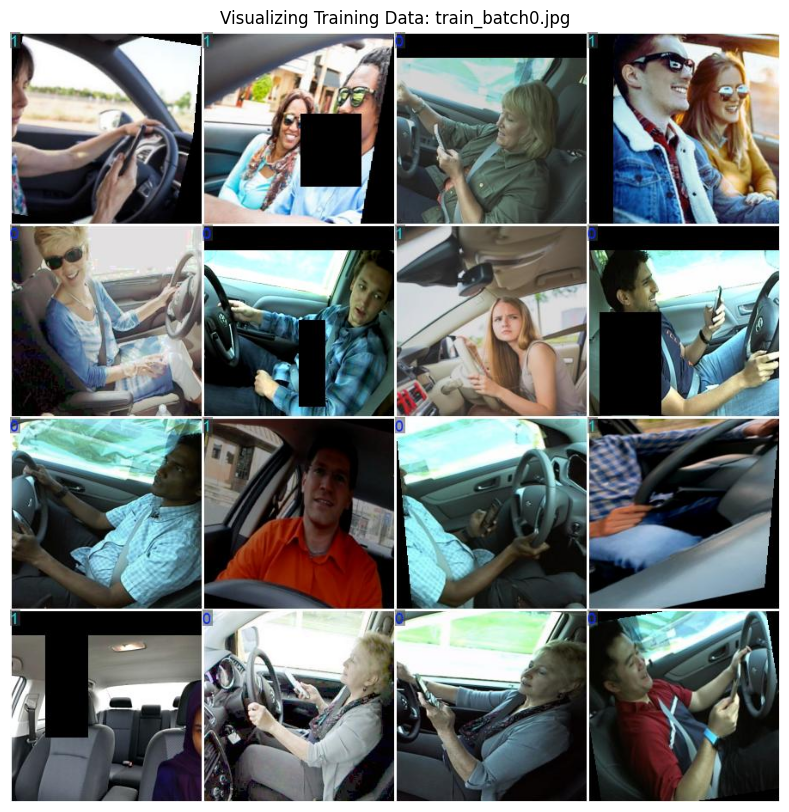

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

save_dir = '/content/seatbelt_project/v1_classification2'

target_image = 'train_batch0.jpg'
path = os.path.join(save_dir, target_image)

if os.path.exists(path):
    plt.figure(figsize=(15, 10))
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.title(f"Visualizing Training Data: {target_image}")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find {target_image} in {save_dir}")

# Model Training
I have used Transfer Learning on the yolov8n-cls.pt (Nano Classification) model. This allowed us to leverage knowledge the model already had about shapes and colors, focusing only on learning the specific features of seatbelts.

In [10]:
from ultralytics import YOLO

# Load the model
model = YOLO('yolov8n-cls.pt')

# Train using the new manual path
model.train(
    data="/content/seatbelt_dataset",
    epochs=20,
    imgsz=224,
    batch=32,
    project='seatbelt_project',
    name='v1_classification'
)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/seatbelt_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=v1_classification2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x791a50e18320>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('/content/seatbelt_project/v1_classification2')
speed: {'preprocess': 0.08646669444434232, 'inference': 0.21874317948727248, 'loss': 0.00016652706577287532, 'postprocess': 0.0017483390317732709}
task: 'classify'
top1: 1.0
top5: 1.0

In [13]:
import os
results_path = '/content/seatbelt_project/v1_classification2'
print(os.listdir(results_path))

['val_batch2_labels.jpg', 'val_batch0_pred.jpg', 'train_batch1762.jpg', 'train_batch1.jpg', 'results.png', 'val_batch0_labels.jpg', 'train_batch1760.jpg', 'weights', 'val_batch2_pred.jpg', 'train_batch0.jpg', 'confusion_matrix_normalized.png', 'results.csv', 'args.yaml', 'train_batch2.jpg', 'confusion_matrix.png', 'val_batch1_pred.jpg', 'val_batch1_labels.jpg', 'train_batch1761.jpg']


Analytics

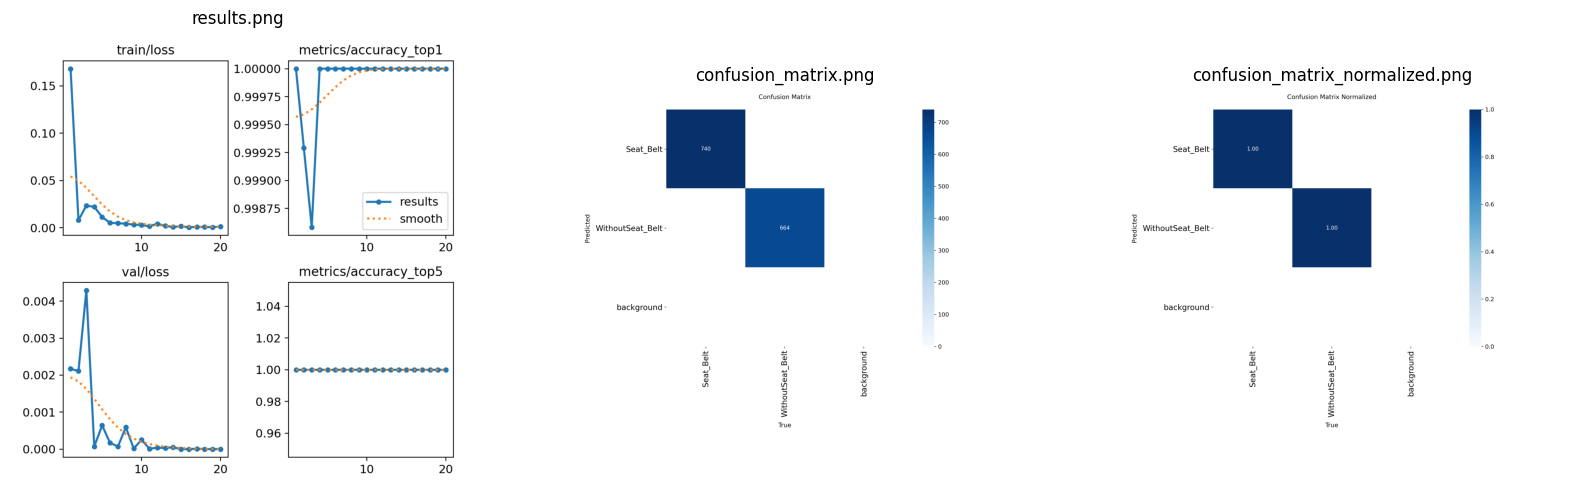

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

save_dir = '/content/seatbelt_project/v1_classification2'


plots = [
    'results.png',
    'confusion_matrix.png',
    'confusion_matrix_normalized.png'
]

plt.figure(figsize=(20, 10))

for i, plot_name in enumerate(plots):
    plot_path = os.path.join(save_dir, plot_name)
    if os.path.exists(plot_path):
        plt.subplot(1, 3, i + 1)
        img = mpimg.imread(plot_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(plot_name)

plt.show()

# Inference and Model Ouput of Random Validation data Samples





--- Testing: seatbelt 1526.jpg ---


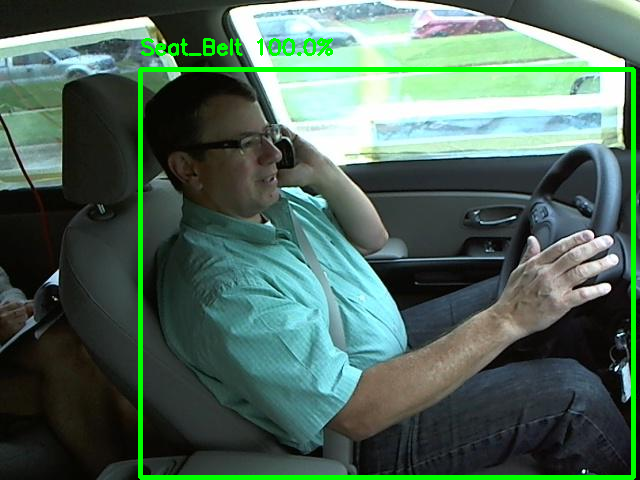


--- Testing: train_witout_seatbelt_original_withoutseatbelt_ 2682.jpg_d99ab7f3-1eb3-4a47-b72a-16e837868dd0.jpg ---


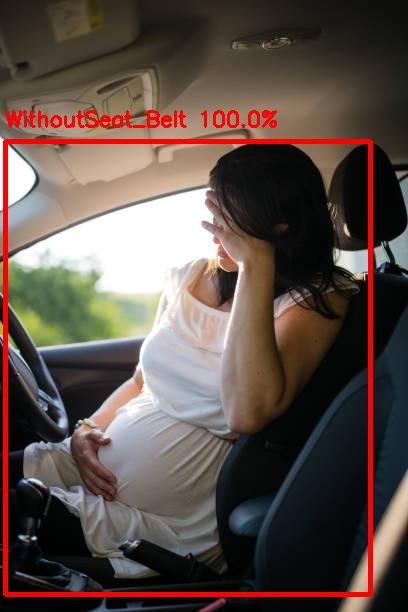


--- Testing: seatbelt 3000.jpg ---


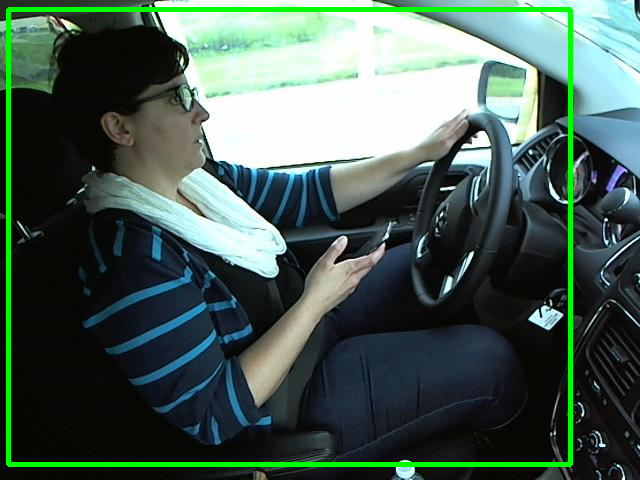

In [42]:
import cv2
import glob
import random
import os
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

detector = YOLO('yolov8n.pt')
classifier = YOLO('/content/seatbelt_project/v1_classification2/weights/best.pt')

def run_test_on_balanced_samples():
    belt_images = glob.glob("/content/seatbelt_dataset/val/Seat_Belt/*.jpg")
    no_belt_images = glob.glob("/content/seatbelt_dataset/val/WithoutSeat_Belt/*.jpg")

    samples = [random.choice(belt_images), random.choice(no_belt_images), random.choice(belt_images + no_belt_images)]

    for path in samples:
        print(f"\n--- Testing: {os.path.basename(path)} ---")
        img = cv2.imread(path)

        results = detector(img, verbose=False)

        for result in results:
            for box in result.boxes:
                if int(box.cls) == 0: # 0 is 'person'
                    x1, y1, x2, y2 = map(int, box.xyxy[0])

                    crop = img[max(0, y1-15):y2+15, max(0, x1-15):x2+15]
                    cls_res = classifier(crop, verbose=False)

                    label = cls_res[0].names[cls_res[0].probs.top1]
                    conf = cls_res[0].probs.top1conf.item()

                    color = (0, 255, 0) if "Without" not in label else (0, 0, 255)

                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
                    cv2.putText(img, f"{label} {conf:.1%}", (x1, y1 - 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        cv2_imshow(img)

run_test_on_balanced_samples()

# Future Enhancements

Video Processing: Implementing this logic on live CCTV feeds or Dashcam footage.

Night Vision: Training on Infrared (IR) datasets to detect seatbelts at night.

Multi-Occupant Tracking: Ensuring the system can track the driver and passenger simultaneously even during movement.